# iLQR-VAE tutorial 

In this tutorial, we will do the following : 

* Introduce the iLQR-VAE model
* Example of the inference of models pre and post-training on the Maze dataset
* Illustration of the flexibility of the inference model


## iLQR-VAE overview

### Generative process 




<img src="figures/generative.png" width="70%"/>




* **Input-driven** latent state dynamics : $\mathbf{z}_{t+1} = f_\theta(\mathbf{z}_t, \mathbf{u}_t, t)$

* Likelihood given latents : $\mathbf{o}_t | \mathbf{z}_t \sim p_\theta(\mathbf{o}_t | \mathbf{z}_t)$

* Student prior over the inputs (favouring *sparse inputs*) : $u_{it} = s_i \epsilon_{it} \sqrt{\nu/\alpha_t}$ with a special Gaussian prior for the initial input (setting initial condition)

* $\mathbf{u}_t \in \mathbb{R}^m$, $\mathbf{z}_t \in \mathbb{R}^n$ and $\mathbf{o}_t \in \mathbb{R}^{n_o}$

* No bottleneck




## Equations

### Inference
To train the model, we optimize $\theta$ to maximize the marginal log-likelihood of observing a collection of independent observation sequences $\mathbf{\mathcal{O}} = \{ \mathbf{o}^{(1)}, \ldots, \mathbf{o}^{(K)} \}$ (trials) given by:
$$
    \log p_\theta(\mathbf{\mathcal{O}})
    =
    \sum_{k=1}^K
    \log \int
    p_\theta(\mathbf{o}^{(k)} |\mathbf{z}(\mathbf{u}))
    p_\theta(\mathbf{u})\,
    d \mathbf{u}
$$

This is intractable, so we instead maximize a lower-bound on this :
$$\mathcal{L}(\mathbf{\mathcal{O}}, \theta, \phi) =
    \sum_k
    \mathbb{E}_{q_\phi(\mathbf{u}|\mathbf{o}^{(k)})}
    \left [
        \log p_\theta(\mathbf{o}^{(k)} | \mathbf{u})
        +
        \log p_\theta(\mathbf{u})
        -
        \log q_\phi(\mathbf{u}|\mathbf{o}^{(k)})
        \right] =
    \sum_k
    \mathbb{E}_{q_\phi(\mathbf{u}|\mathbf{o}^{(k)})}
    \left [
        \sum_{t=1}^T
        \log p_\theta(\mathbf{o}_t^{(k)} | \mathbf{z}_t)
        +
        \log p_\theta(\mathbf{u}_t)
        -
        \log q_\phi(\mathbf{u}_t|\mathbf{o}^{(k)}) \right]           \\
        \leq \log p_\theta(\mathbf{\mathcal{O}}).$$

We need an expression for $\log q_\phi(\mathbf{u}_t|\mathbf{o}^{(k)})$ : one way is to use a Gaussian approximation parameterized with RNNs (as in LFADS). Here, we instead use an *optimization-based* inference module. 

We parametrize the mean of the approximate posterior using the inputs *maximizing the exact log posterior*, i.e. 
        
 $$\mathbf{u}^\star(\mathbf{o}^{(k)})
      = \underset{\mathbf{u}}{\text{argmax}}\: \log p_\theta(\mathbf{u}|\mathbf{o}^{(k)}) \\
      = \underset{\mathbf{u}}{\text{argmax}} \left[
        \sum_{t=1}^T \log p_\theta(\mathbf{o}_t^{(k)} | \mathbf{u})
        + \log p_\theta(\mathbf{u}_t)
        \right]$$
        
We find these using **iLQR**, such that 
$\mathbf{u}^\star(\mathbf{o}) =
    \text{iLQRsolve}(\mathbf{o}, \theta).$
    
    
This has the advantage that we don't need to introduce new parameters for the inference (at least for the mean), and reduces the number of hyperparameters to optimize. 

### Full model

<img src="figures/model.png" width="70%"/>

## Load the libraries 

In [2]:
#use_output "dune top"

open Owl
open Ilqr_vae
open Tutorial_lib
open Gp

### Define the generative model 

In [3]:
type setup =
  { n : int
  ; m : int
  ; n_trials : int
  ; n_steps : int
  ; n_neural : int
  }

let n = 90
let m = 15
let dt = 5E-3
let n_neurons = 137
let n_beg = n / m
let setup = { n; m; n_trials = 1; n_steps = 140; n_neural = n_neurons }

(* Define the prior*)
module U = Prior.Student (struct
  let n_beg = n / m
  let m = m
end)

(*Choose the type of likelihood (e.g Poisson for spikes, Gaussian for calcium imaging)*)
module L = Likelihood.Poisson (struct
  let label = "neural"
  let dt = AD.F dt
  let link_function = AD.Maths.exp
  let d_link_function = AD.Maths.exp
  let d2_link_function = AD.Maths.exp
  let n_output = n_neurons
  let n = n
end)

(*Choose the dynamics (e.g GRU RNN)*)
module D = Dynamics.Mini_GRU_IO (struct
  let phi x = AD.Maths.(AD.requad x - F 1.)
  let d_phi x = AD.d_requad x
  let sigma x = AD.Maths.sigmoid x
  let d_sigma x = AD.Maths.(exp (neg x) / sqr (F 1. + exp (neg x)))
  let m = m
  let n = n
  let n_beg = Some (n / m)
end)

(*define the hyperparameters for this dataset : latent space dimension n, number of input channels m *)
module X = struct
  let n = setup.n
  let m = setup.m
  let n_steps = setup.n_steps
  let diag_time_cov = false
  let n_beg = n_beg
end

let () = Jupyter_notebook.clear_output ()

### Define the full model

In [4]:
module Make_model
    (U : Prior.T)
    (D : Dynamics.T)
    (L : Likelihood.T) (S : sig
      val n_steps : int
    end) =
struct
  module G = Generative.Make (U) (D) (L)

  (* here we use ILQR as the recognition model, but our codebase
     allows substituting this with e.g. biRNNs, yielding a model
     similar to LFADS *)
  module R =
    Recognition.ILQR (U) (D) (L)
      (struct
        let conv_threshold = 1E-6
        let reuse_u = `never
        let diag_time_cov = false
        let n_steps = S.n_steps
      end)

  module Model = Vae.Make (G) (R)
end

module Model = Make_model (U) (D) (L) (X)

let () = Jupyter_notebook.clear_output ()

### Load the data

In [5]:
open Owl_parameters
open Base
open Vae

let train_spikes = Arr.load_npy "nlb/train_spikes_0.npy"
let n_train_neurons = 137
let n_test_neurons = 45
let n_neurons = n_train_neurons + n_test_neurons

let trial =
  let open Likelihood.Poisson_P in
  let x =
    Arr.get_slice [ [ 0 ] ] train_spikes |> fun z -> Arr.reshape z [| -1; n_neurons |]
  in
  let o = AD.pack_arr x in
  Data.pack o

val train_spikes : Owl.Arr.arr = <abstr>


val n_train_neurons : int = 137


val n_test_neurons : int = 45


val n_neurons : Base.Int.t = 182


val trial : ([ `o ], Ilqr_vae.AD.t) Ilqr_vae.Data.t = <abstr>


### Visualize the data 

val spikes_to_plot : Owl.Arr.arr = <abstr>


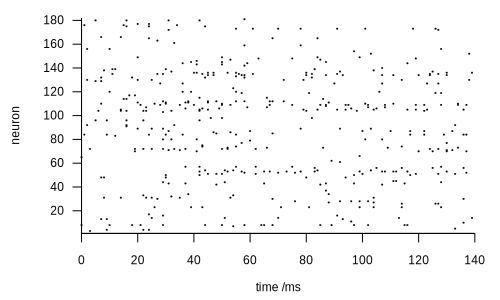

In [6]:
let spikes_to_plot =
  Arr.get_slice [ [ 0 ] ] train_spikes |> fun z -> Arr.reshape z [| -1; n_neurons |]

let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 182 (fun i ->
           let st = "p pt 7 ps 0.2 lc black" in
           let fi = Float.of_int i in
           let arr = Arr.get_slice [ []; [ i ] ] spikes_to_plot in
           let arr = Arr.(fi $* arr) in
           item (A arr) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "neuron"; yrange (1., 182.) ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

## Training the model : 
* We need to learn the **generative** parameters of the model and the **posterior covariance**
* This is done by optimizing the ELBO
* To train the model, we use Adam with a sqrt decaying learning rate (to be optimized)
* The training is parallelized over CPUs and typically takes ~6-8h on 168 CPUs with a batch size of 168 
* Here, we will load a pre-trained model and show how iLQR works as an inference module

In [7]:
include Vae_typ
open Vae_typ.P
open Model

module P = Ilqr_vae.Vae_typ.P


### Define a function to return the mean firing rates + inputs 

In [8]:
let get_us_and_rates gen_prms prms trial =
  let u_mean, all_us, zs =
    let u_mean, all_us =
      R.posterior_mean ~gen_prms:prms.generative prms.recognition trial
    in
    let u = AD.Maths.reshape u_mean [| 1; -1; AD.Mat.col_num u_mean |] in
    let zs = G.integrate ~prms:prms.generative ~u in
    (*this is of size n_samples x n-steps x n_output *)
    let remove_n_beg = AD.Maths.get_slice [ []; [ G.n_beg - 1; -1 ] ] in
    remove_n_beg u_mean, all_us, remove_n_beg zs
  in
  let z_mean =
    Arr.mean ~axis:0 (AD.unpack_arr zs)
    |> fun x -> Arr.reshape x [| -1; (Arr.shape x).(2) |]
  in
  let z_mean = AD.pack_arr z_mean in
  let open Vae_typ.P in
  let open Prior_typ in
  let open Generative_typ.P in
  let open Likelihood.Poisson_P in
  let c = Owl_parameters.extract gen_prms.generative.likelihood.c in
  let bias = Owl_parameters.extract gen_prms.generative.likelihood.bias in
  let gain = Owl_parameters.extract gen_prms.generative.likelihood.gain in
  AD.Maths.(gain * exp ((z_mean *@ transpose c) + bias)) |> AD.unpack_arr, all_us

val get_us_and_rates :
  (('a, 'b,
    Owl_algodiff.D.t Owl_parameters.tag Ilqr_vae.Likelihood.Poisson_P.prm)
   Ilqr_vae.Generative_typ.P.prm_, 'c)
  Ilqr_vae.Vae_typ.P.prm_ ->
  (Model.R.G.P.p, Model.R.P.p) Ilqr_vae.Vae_typ.P.prm_ ->
  ([> `o ], Model.R.G.L.output) Ilqr_vae.Data.t ->
  Ilqr_vae.AD.A.arr * Ilqr_vae.AD.t list = <fun>


## Pre training 

val prms : 'a = <poly>


val uf : Ilqr_vae.AD.A.arr = <abstr>


val c : Ilqr_vae.AD.A.arr = <abstr>


val figure : (module Gp.Plot) -> unit = <fun>


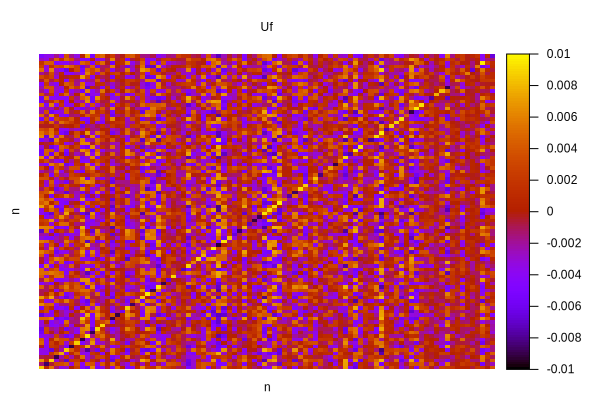

val figure : (module Gp.Plot) -> unit = <fun>


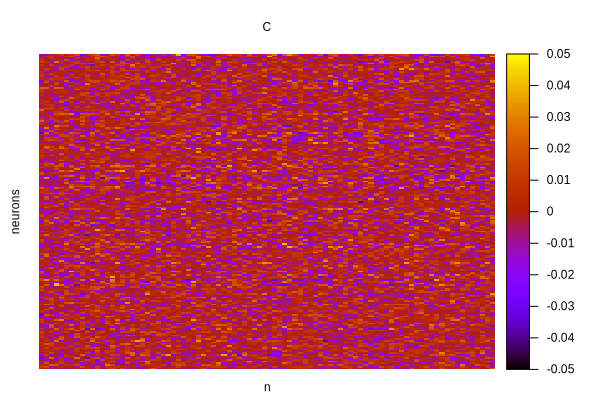

val rates : Ilqr_vae.AD.A.arr = <abstr>
val all_us : Ilqr_vae.AD.t list =
  [Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>]


In [9]:
open Generative.P

(*load random set of initial parameters and plot the dynamics/readout*)

let prms = Misc.load_bin "progress_0.params.bin"

let uf =
  let open Dynamics.Mini_GRU_IO_P in
  Owl_parameters.extract prms.generative.dynamics.uf |> AD.unpack_arr

let c =
  let open Likelihood.Poisson_P in
  Owl_parameters.extract prms.generative.likelihood.c |> AD.unpack_arr

let figure (module P : Plot) =
  P.heatmap
    (`mat uf)
    ~style:"image pixels"
    ([ barebone ] @ [ title "Uf" ] @ [ xlabel "n" ] @ [ ylabel "n" ] @ [ cbtics `auto ])

let () = Juplot.draw ~fmt:`svg figure

let figure (module P : Plot) =
  P.heatmap
    (`mat c)
    ~style:"image pixels"
    ([ barebone ]
    @ [ title "C" ]
    @ [ xlabel "n" ]
    @ [ ylabel "neurons" ]
    @ [ cbtics `auto ])

let () = Juplot.draw ~fmt:`svg figure

(*perform inference with these initial parameters*)
let rates, all_us = get_us_and_rates prms prms trial

### Plot the input over the course of optimization

val plot_us_init :
  Ilqr_vae.AD.t Base.List.t -> int -> (module Gp.Plot) -> unit = <fun>


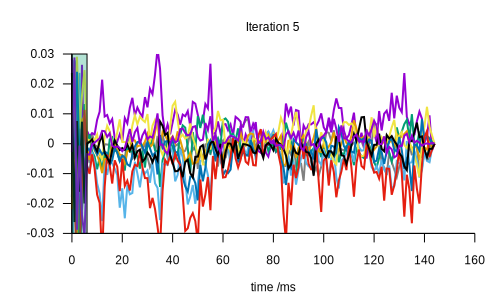

- : unit = ()


In [10]:
let plot_us_init all_us i (module P : Plot) =
  let it_title = Printf.sprintf "Iteration %i" i in
  let u = List.nth_exn all_us i in
  let u = AD.unpack_arr u |> fun z -> Arr.reshape z [| -1; 15 |] in
  P.plots
    (List.init 10 (fun i ->
         let st = Printf.sprintf "l lw 2 lc %i" i in
         item (A (Arr.get_slice [ []; [ i ] ] u)) ~style:st))
    (default_props
    @ [ xlabel "time /ms"
      ; ylabel ""
      ; title it_title
      ; yrange (-0.03, 0.03)
      ; set "object rect from 0,-0.05 to 6,0.05 fc lt 2 fs transparent solid 0.3 front"
      ])

let _ =
  let open Gp in
  let display_id = Jupyter_notebook.display "text/html" "" in
  List.iter
    (List.init (List.length all_us) ~f:(fun i -> i))
    (fun phase ->
      Juplot.draw ~fmt:`svg ~size:(500, 300) ~display_id (plot_us_init all_us phase);
      Unix.sleepf 0.6)

### Plot the firing rates inferred initially

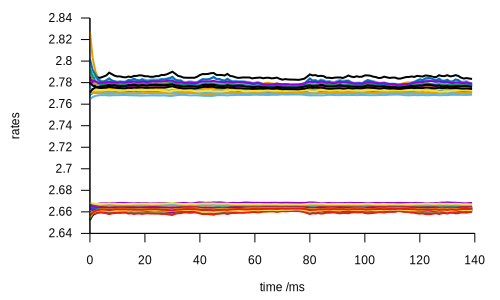

In [11]:
let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 50 (fun i ->
           let st = Printf.sprintf "l lw 2 lc %i" i in
           item (A (Arr.get_slice [ []; [ 2 * i ] ] rates)) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "rates" ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

* With random initial parameters (no dynamics), iLQR fails to explain firing rates that explain the data well. 

## After training 

val prms : 'a = <poly>


val rates : Ilqr_vae.AD.A.arr = <abstr>
val all_us : Ilqr_vae.AD.t list =
  [Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>]


val uf : Ilqr_vae.AD.A.arr = <abstr>


val c : Ilqr_vae.AD.A.arr = <abstr>


val figure : (module Gp.Plot) -> unit = <fun>


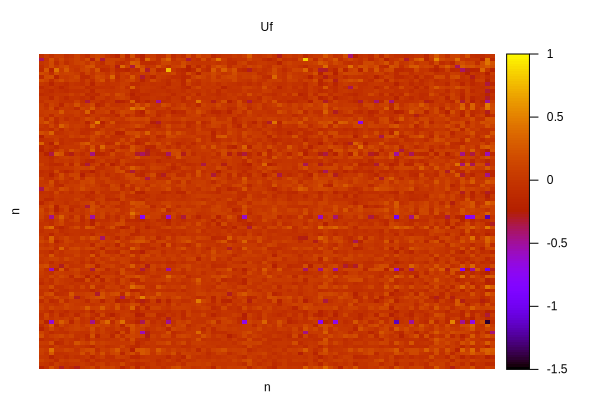

val figure : (module Gp.Plot) -> unit = <fun>


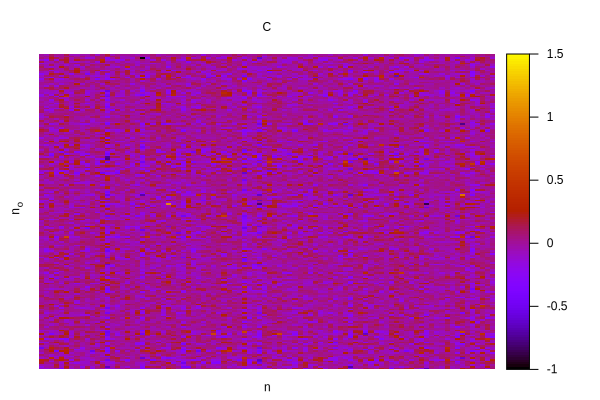

In [12]:
let prms = Misc.load_bin "progress_3500.params.bin"
let rates, all_us = get_us_and_rates prms prms trial

let uf =
  let open Dynamics.Mini_GRU_IO_P in
  Owl_parameters.extract prms.generative.dynamics.uf |> AD.unpack_arr

let c =
  let open Likelihood.Poisson_P in
  Owl_parameters.extract prms.generative.likelihood.c |> AD.unpack_arr

let figure (module P : Plot) =
  P.heatmap
    (`mat uf)
    ~style:"image pixels"
    ([ barebone ] @ [ title "Uf" ] @ [ xlabel "n" ] @ [ ylabel "n" ] @ [ cbtics `auto ])

let () = Juplot.draw ~fmt:`svg figure

let figure (module P : Plot) =
  P.heatmap
    (`mat c)
    ~style:"image pixels"
    ([ barebone ] @ [ title "C" ] @ [ xlabel "n" ] @ [ ylabel "n_o" ] @ [ cbtics `auto ])

let () = Juplot.draw ~fmt:`svg figure

val plot_us_fin :
  Ilqr_vae.AD.t Base.List.t -> int -> (module Gp.Plot) -> unit = <fun>


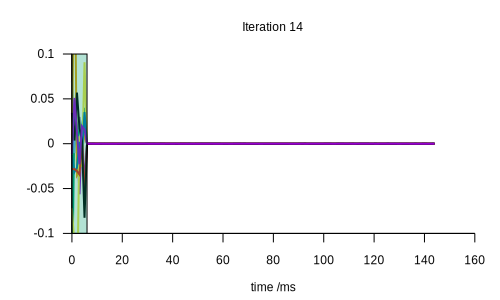

- : unit = ()


In [13]:
let plot_us_fin all_us i (module P : Plot) =
  let it_title = Printf.sprintf "Iteration %i" i in
  let u = List.nth_exn all_us i in
  let u = AD.unpack_arr u |> fun z -> Arr.reshape z [| -1; 15 |] in
  P.plots
    (List.init 10 (fun i ->
         let st = Printf.sprintf "l lw 2 lc %i" i in
         item (A (Arr.get_slice [ []; [ i ] ] u)) ~style:st))
    (default_props
    @ [ xlabel "time /ms"; ylabel ""; title it_title; yrange (-0.1, 0.1) ]
    @ [ set "object rect from 0,-0.1 to 6,0.1 fc lt 2 fs transparent solid 0.3 front" ])

let _ =
  let open Gp in
  let display_id = Jupyter_notebook.display "text/html" "" in
  List.iter
    (List.init (List.length all_us) ~f:(fun i -> i))
    (fun phase ->
      Juplot.draw ~fmt:`svg ~size:(500, 300) ~display_id (plot_us_fin all_us phase);
      Unix.sleepf 0.3)

* Interestingly, even though iLQR-VAE assumes input-driven dynamics by default, here it fits the data using autonomous dynamics. 

### Trained

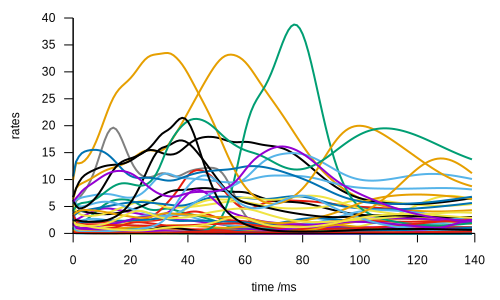

In [14]:
let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 50 (fun i ->
           let st = Printf.sprintf "l lw 2 lc %i" i in
           item (A (Arr.get_slice [ []; [ 2 * i ] ] rates)) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "rates" ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

### Flexible co-smoothing

* A key advantage of iLQR-VAE is the flexibility of its inference model

* Given a set of generative parameters, inference can be performed on heterogeneous data

* For instance we can train the model on all the neurons, but at test time evaluate the same model on a subset of the neurons by using **a subset of the readout matrix** to get the latents, and then predict firing rates for all neurons using the **full readout**



In [15]:
let eval_spikes_in = Arr.load_npy "nlb/eval_spikes_in_0.npy"
let eval_spikes_out = Arr.load_npy "nlb/eval_spikes_out_0.npy"
let n_neurons_eval = (Arr.shape eval_spikes_in).(2)

let test_trial =
  let open Likelihood.Poisson_P in
  let x =
    Arr.get_slice [ [ 0 ] ] eval_spikes_in
    |> fun z -> Arr.reshape z [| -1; n_train_neurons |]
  in
  let o = AD.pack_arr x in
  Data.pack o

(*select only the readout parameters of the held-in neurons*)

let masked_prms =
  let masked_likelihood ~prms =
    let open Vae_typ.P in
    let open Prior_typ in
    let open Generative_typ.P in
    let open Likelihood.Poisson_P in
    let c = Owl_parameters.extract prms.c in
    let bias = Owl_parameters.extract prms.bias in
    let gain = Owl_parameters.extract prms.gain in
    Likelihood.Poisson_P.
      { c = pinned (AD.Maths.get_slice [ [ 0; n_train_neurons - 1 ] ] c)
      ; bias = pinned (AD.Maths.get_slice [ []; [ 0; n_train_neurons - 1 ] ] bias)
      ; c_mask = None
      ; gain = pinned (AD.Maths.get_slice [ []; [ 0; n_train_neurons - 1 ] ] gain)
      }
  in
  { generative =
      { prior = prms.generative.prior
      ; dynamics = prms.generative.dynamics
      ; likelihood = masked_likelihood ~prms:prms.generative.likelihood
      }
  ; recognition = prms.recognition
  }

let rates, all_us = get_us_and_rates prms masked_prms test_trial

val eval_spikes_in : Owl.Arr.arr = <abstr>


val eval_spikes_out : Owl.Arr.arr = <abstr>


val n_neurons_eval : int = 137


val test_trial : ([ `o ], Ilqr_vae.AD.t) Ilqr_vae.Data.t = <abstr>


val masked_prms :
  (('a, 'b, Owl_parameters.t Ilqr_vae.Likelihood.Poisson_P.prm)
   Ilqr_vae.Generative.P.prm_, 'c)
  Ilqr_vae.Vae_typ.P.prm_ =
  {generative =
    {prior = <poly>; dynamics = <poly>;
     likelihood =
      {Ilqr_vae.Likelihood.Poisson_P.c =
        Pinned (Owl_parameters__.AD.Arr <abstr>);
       c_mask = Base.Option.None;
       bias = Pinned (Owl_parameters__.AD.Arr <abstr>);
       gain = Pinned (Owl_parameters__.AD.Arr <abstr>)}};
   recognition = <poly>}


val rates : Ilqr_vae.AD.A.arr = <abstr>
val all_us : Ilqr_vae.AD.t list =
  [Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>]


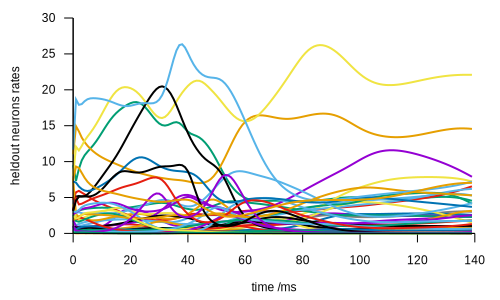

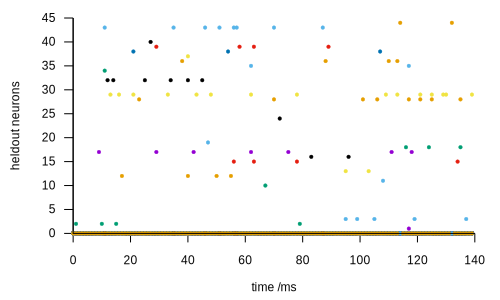

In [16]:
let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 45 (fun i ->
           let st = Printf.sprintf "l lw 2 lc %i" i in
           item (A (Arr.get_slice [ []; [ 137 + i ] ] rates)) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "heldout neurons rates" ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

let () =
  let spikes_to_plot =
    Arr.get_slice [ [ 0 ] ] eval_spikes_out
    |> fun z -> Arr.reshape z [| -1; n_test_neurons |]
  in
  let fig (module P : Plot) =
    P.plots
      (List.init 45 (fun i ->
           let st = Printf.sprintf "p pt 7 ps 0.4 lc %i" i in
           let fi = Float.of_int i in
           let arr = Arr.get_slice [ []; [ i ] ] spikes_to_plot in
           let arr = Arr.(fi $* arr) in
           item (A arr) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "heldout neurons"; yrange (0., 45.) ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

### Flexible inference on heterogeneous time series

* The flexible inference model can be used to fit *longer* or *shorter trials* than the data it was trained on

In [17]:
(*take only the first 50ms of the evaluation data *)
let train_spikes_short = train_spikes |> fun z -> Arr.get_slice [ [ 0 ]; [ 0; 50 ] ] z

let test_trial_short =
  let open Likelihood.Poisson_P in
  let x = train_spikes_short |> fun z -> Arr.reshape z [| -1; n_neurons |] in
  let o = AD.pack_arr x in
  Data.pack o

module R =
  Recognition.ILQR (U) (D) (L)
    (struct
      let conv_threshold = 1E-6
      let reuse_u = `never
      let diag_time_cov = false
      let n_steps = (Arr.shape train_spikes_short).(1)
    end)

let short_rates, _ =
  let u_mean, all_us, zs =
    let u_mean, all_us =
      R.posterior_mean ~gen_prms:prms.generative prms.recognition test_trial_short
    in
    let u = AD.Maths.reshape u_mean [| 1; -1; AD.Mat.col_num u_mean |] in
    let zs = G.integrate ~prms:prms.generative ~u in
    let remove_n_beg = AD.Maths.get_slice [ []; [ G.n_beg - 1; -1 ] ] in
    remove_n_beg u_mean, all_us, remove_n_beg zs
  in
  let z_mean =
    Arr.mean ~axis:0 (AD.unpack_arr zs)
    |> fun x -> Arr.reshape x [| -1; (Arr.shape x).(2) |]
  in
  let z_mean = AD.pack_arr z_mean in
  let open Vae_typ.P in
  let open Prior_typ in
  let open Generative_typ.P in
  let open Likelihood.Poisson_P in
  let c = Owl_parameters.extract prms.generative.likelihood.c in
  let bias = Owl_parameters.extract prms.generative.likelihood.bias in
  let gain = Owl_parameters.extract prms.generative.likelihood.gain in
  AD.Maths.(F dt * gain * exp ((z_mean *@ transpose c) + bias)) |> AD.unpack_arr, all_us

val train_spikes_short : Owl.Arr.arr = <abstr>


val test_trial_short : ([ `o ], Ilqr_vae.AD.t) Ilqr_vae.Data.t = <abstr>


module R :
  sig
    module G :
      sig
        val n : int
        val m : int
        val n_beg : int
        module U :
          sig
            module P :
              sig
                type 'a prm = 'a U.P.prm
                val map : f:('a -> 'b) -> 'a prm -> 'b prm
                val fold :
                  ?prefix:Base.String.t ->
                  init:'a ->
                  f:('a -> 'b * Base.String.t -> 'a) -> 'b prm -> 'a
                type p = Owl_parameters.t prm
                type ph = Owl_parameters.h prm
                val pack : (module Owl_parameters.Packer) -> p -> ph
                val unpack : ph -> Owl_parameters__.AD.t -> p
                val save_to_files :
                  ?zip:Base.bool -> ?prefix:Base.String.t -> p -> Base.unit
              end
            val m : Base.int
            val n_beg : Base.int
            val requires_linesearch : Base.bool
            val spatial_stds : prms:P.p -> Ilqr_vae.AD.t
            val sample : prms:P

val short_rates : Ilqr_vae.AD.A.arr = <abstr>


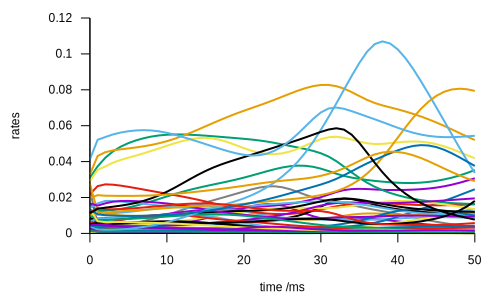

In [18]:
let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 45 (fun i ->
           let st = Printf.sprintf "l lw 2 lc %i" i in
           item (A (Arr.get_slice [ []; [ 137 + i ] ] short_rates)) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "rates" ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig